In [16]:
#imports
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from scipy.stats import chi2_contingency
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
#reading the csv file
dir  = globals()['_dh'][0].parent
file_path = dir / 'data' / 'cleaned_data.pkl'
df = pd.read_pickle(file_path)
print(df.shape)
df.head(5)


(16680, 16)


,OrgID,EnrollDate,ChurnDate,OrgSize,Industry,IndustryGroup,Enrollment Plan,PromoType,Acquisition Channel,F28 Active Rate,Avg Lifetime Active,F28 Cc Flag,eLTV/CAC,Churned,Enrollment Duration,User_id
0,44,2021-02-01,NaT,0-1,Flooring,Other,Extra large,No Promo,Marketing - Paid,0.607,0.096,0,4.1,0,676.0,4420210201
1,70,2022-03-01,NaT,0-1,Plumbing,Plumbing,Starter,No Promo,NaN,0.071,0.340,0,1.2,0,283.0,7020220301
2,1494,2020-10-02,NaT,0-1,Carpet Cleaning,Carpet Cleaning,Small,No Promo,Product,1.000,0.379,1,3.4,0,798.0,149420201002
3,1604,2020-10-08,2020-12-08,11+,Restoration,Other,Large,2+ month,Sales,0.500,0.004,0,6.2,1,61.0,160420201008
4,1652,2020-02-03,2020-03-02,11+,Solar & Energy,Other,Large,One Month,Sales,0.000,0.001,0,4.7,1,28.0,165220200203


## 1 - Analysing
Findings: \
Enrollment Duration seems to be a clear variable for churn \
After 334.0 days, users are very unlikely to churn. Need to validate further the database because this behavior seems synthetic \
Most of the churn happens in the first 90 days, in spikes possibly when the monthly subscription end \
Churned users tend to be less active overall \
If the Cc flag = 1 the churn rate is lower

In [18]:
df['OrgID'].nunique()

16544

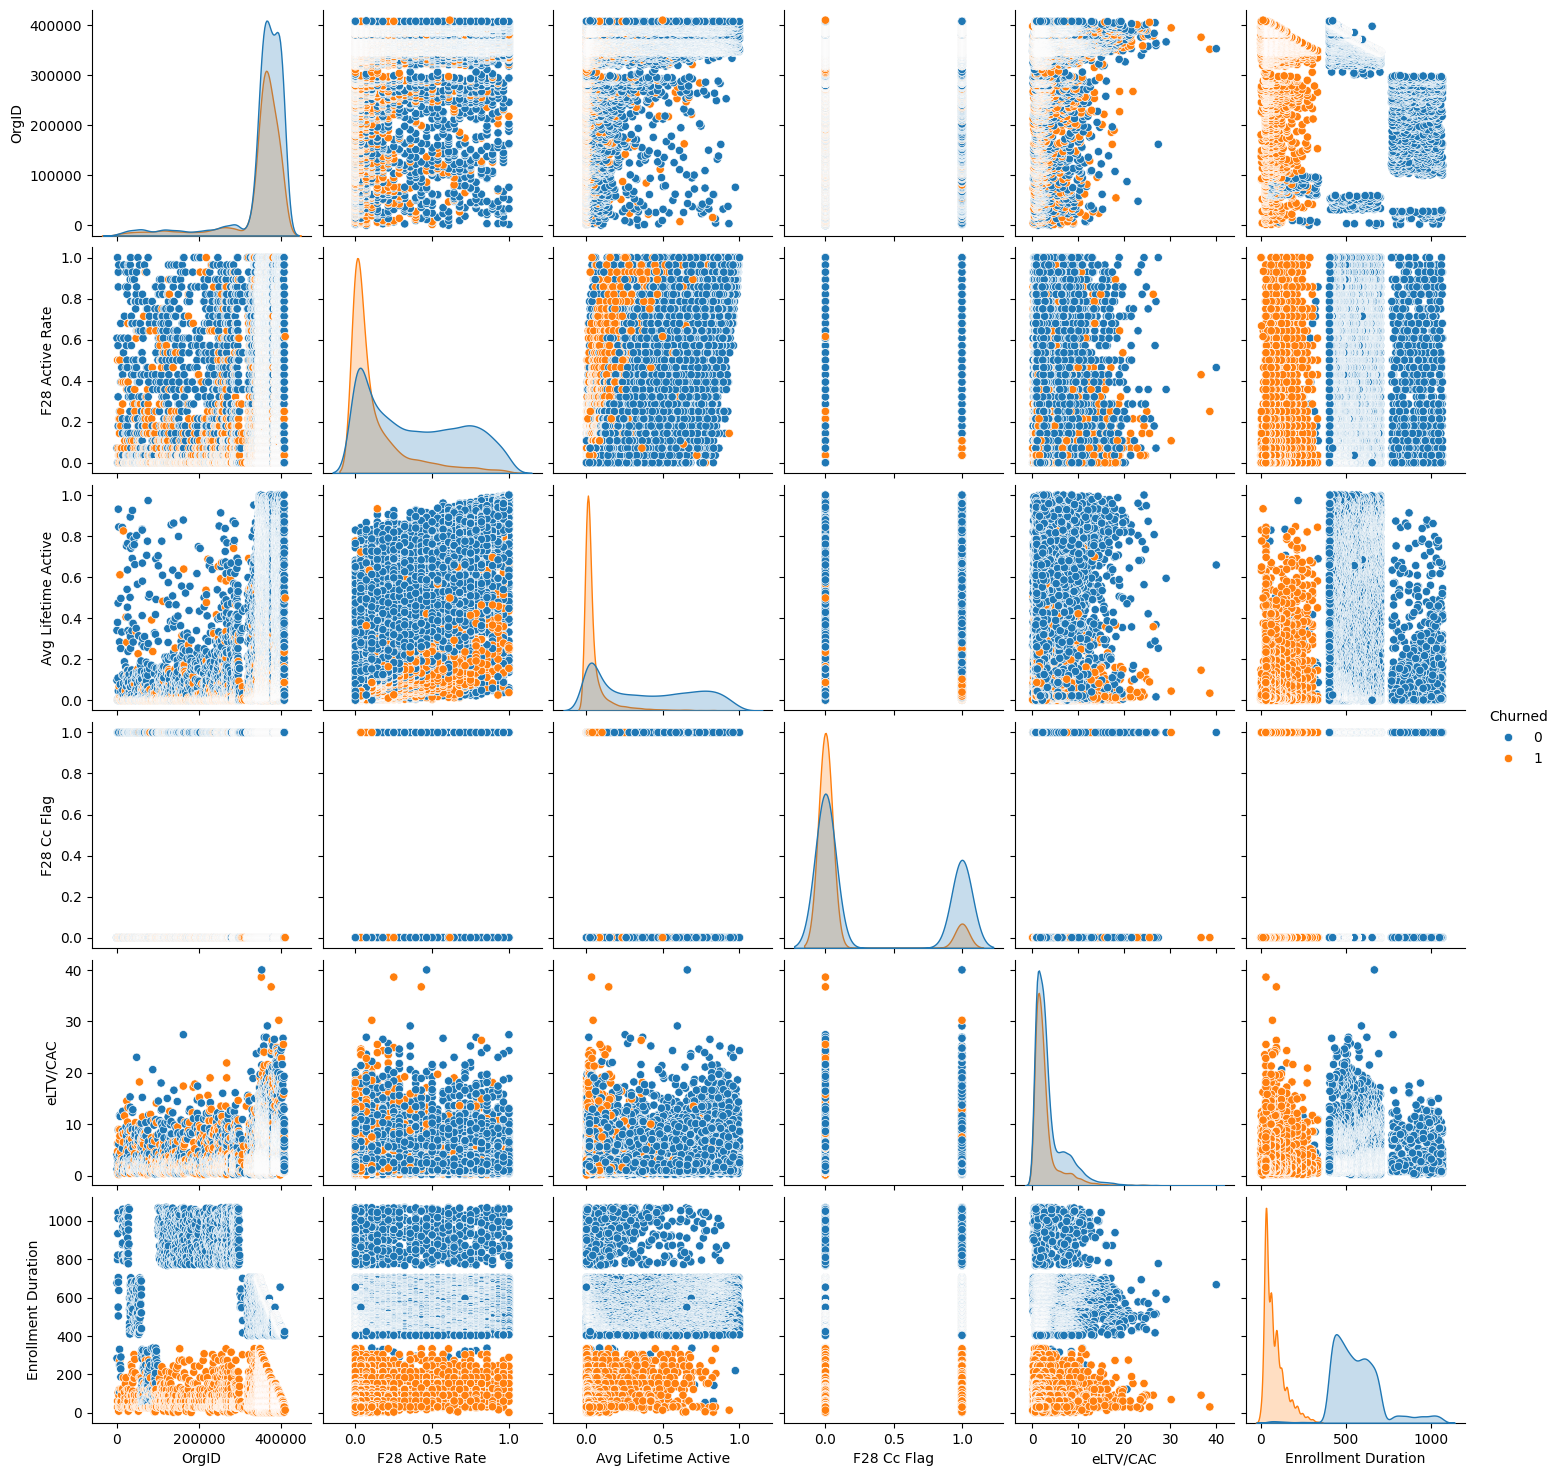

In [19]:
sns.pairplot(df, hue='Churned')

In [20]:
#max ChurnDate
max_churn_enrollment = df[df['Churned'] == 1]['Enrollment Duration'].max()
print(f'Max Churned Enrollment: {max_churn_enrollment}')

Max Churned Enrollment: 334.0


In [21]:
df_churned = df[df['Churned'] == 1]

In [22]:
df[df['F28 Cc Flag'] == 1]['F28 Cc Flag'].count() / df.shape[0]

0.2581534772182254

In [23]:
cc_0 = df_churned[df_churned['F28 Cc Flag'] == 0]['F28 Cc Flag'].count() / df[df['F28 Cc Flag'] == 0]['F28 Cc Flag'].count() * 100
cc_1 = df_churned[df_churned['F28 Cc Flag'] == 1]['F28 Cc Flag'].count() / df[df['F28 Cc Flag'] == 1]['F28 Cc Flag'].count() * 100

print(f'CC_1 Churn Ratio: {cc_1:.0f}%')
print(f'CC_0 Churn Ratio: {cc_0:.0f}%')

CC_1 Churn Ratio: 16%
CC_0 Churn Ratio: 49%


In [24]:
f28 = df[df['Churned'] == 0]['F28 Active Rate'].mean() * 100
f28_churned = df_churned['F28 Active Rate'].mean() * 100

print(f'CF28 mean activity rate: {f28:.0f}%')
print(f'Churned CF28 mean activity rate : {f28_churned:.0f}%')

CF28 mean activity rate: 38%
Churned CF28 mean activity rate : 13%


In [25]:
active = df[df['Churned'] == 0]['Avg Lifetime Active'].mean() * 100
active_churned = df_churned['Avg Lifetime Active'].mean() * 100

print(f'CF28 mean activity rate: {active:.0f}%')
print(f'Churned CF28 mean activity rate : {active_churned:.0f}%')

CF28 mean activity rate: 38%
Churned CF28 mean activity rate : 5%


In [26]:
df_sales = df[df['Acquisition Channel'] == 'Sales']

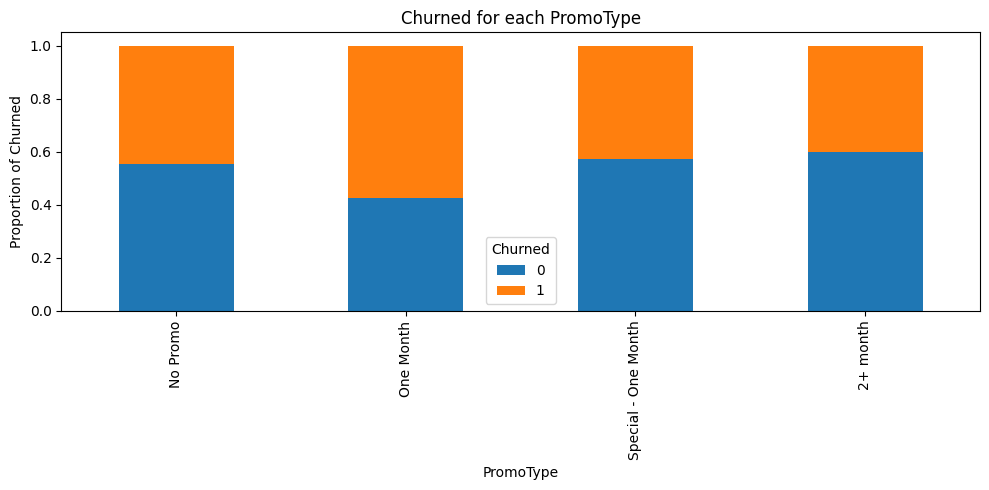

In [27]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Group by PromoType and Churned, count occurrences, and unstack for plotting
grouped = df_sales[df_sales['Churned'].notnull()].groupby(['PromoType', 'Churned']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('Churned for each PromoType')
ax.set_ylabel('Proportion of Churned')  # Change to 'Count' if not normalizing
ax.set_xlabel('PromoType')

# Display the plot
plt.tight_layout()
plt.show()

In [28]:
def cramers_v(x, y):
    """Calculate Cramér's V correlation between two categorical variables"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_v(df['Acquisition Channel'], df['PromoType'])

0.23723219973507634

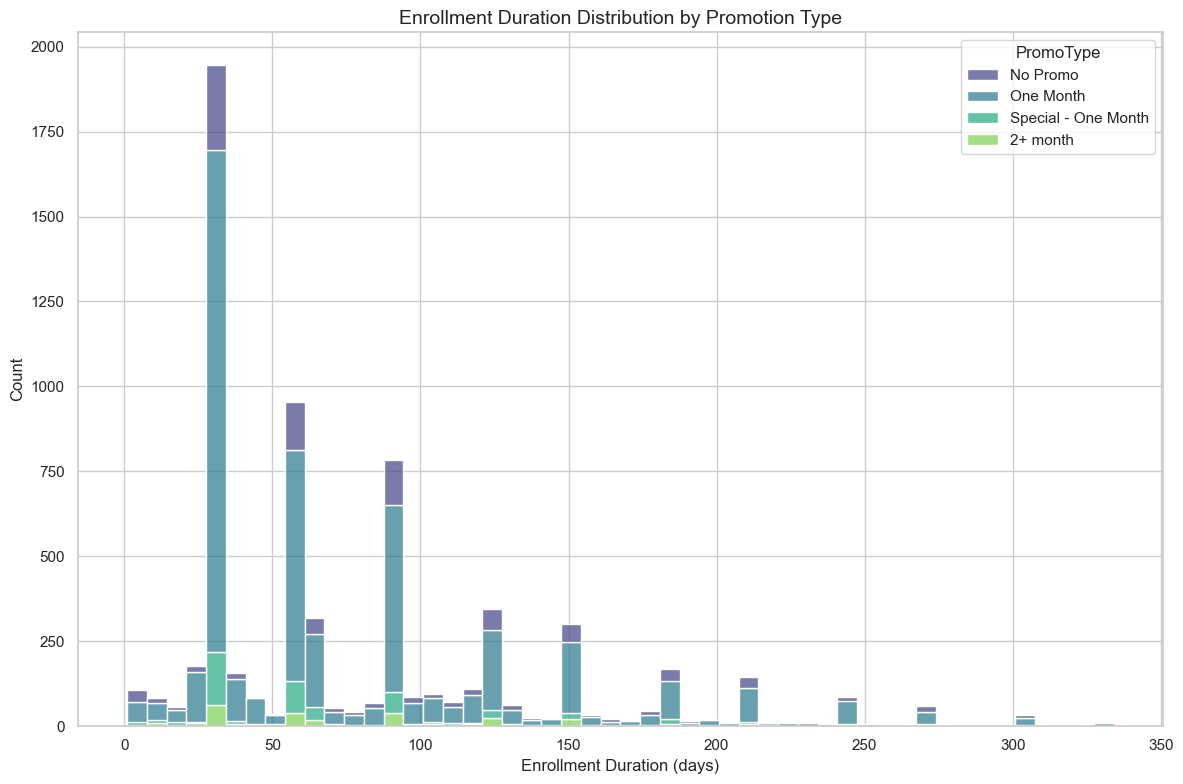

In [29]:

# Set the style for better visualization
sns.set(style="whitegrid")

# Create a figure with sufficient size
plt.figure(figsize=(12, 8))

# Define a custom color palette - you can choose different color schemes
# Options include: 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Set1', 'Set2', 'tab10', etc.
custom_palette = sns.color_palette("viridis", 4)  # Adjust the number based on your categories

# Create histograms for each Promotype category with the new color scheme
ax = sns.histplot(
    data=df_churned, 
    x="Enrollment Duration",
    hue="PromoType",
    multiple="stack",
    bins=50,
    alpha=0.7,
    palette=custom_palette
)

# Add labels and title
plt.xlabel('Enrollment Duration (days)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Enrollment Duration Distribution by Promotion Type', fontsize=14)

# Fix the legend - ensure it's shown with proper formatting
# Move it outside the plot to prevent overlap with data
#plt.legend(title='Promotion Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()



In [30]:
#percentual of users that churned in the first 100 days:
df_churned[df_churned['Enrollment Duration'] <= 100].shape[0] / df_churned.shape[0] * 100


73.83261226316574

In [31]:
#percentual of users that churned in the first 30 days:
df_churned[df_churned['Enrollment Duration'] <= 30].shape[0] / df_churned.shape[0] * 100

30.463971356109205

In [32]:
#mean ltv/cac ratio
df['eLTV/CAC'].mean()

3.3493745845670433

In [33]:
df['Enrollment Duration'].mean()

369.9643285371703

In [34]:
df_churned['Enrollment Duration'].mean()

79.52394450246159

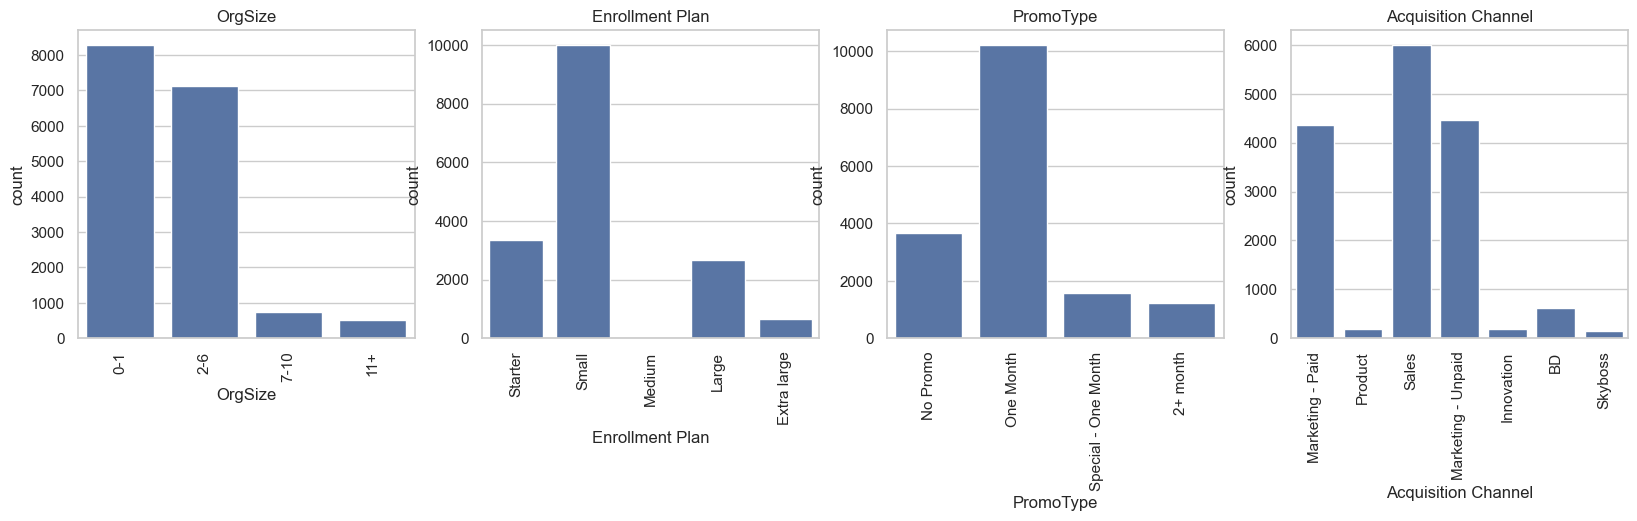

In [22]:
cols = ['OrgSize',"Enrollment Plan", 'PromoType', 'Acquisition Channel']
numerical = cols

plt.figure(figsize=(20,4))

for i, col in enumerate(numerical):
    ax = plt.subplot(1, len(numerical), i+1)
    sns.countplot(x=str(col), data=df)
    ax.set_title(f"{col}")
    #rotate x-axis labels
    plt.xticks(rotation=90)

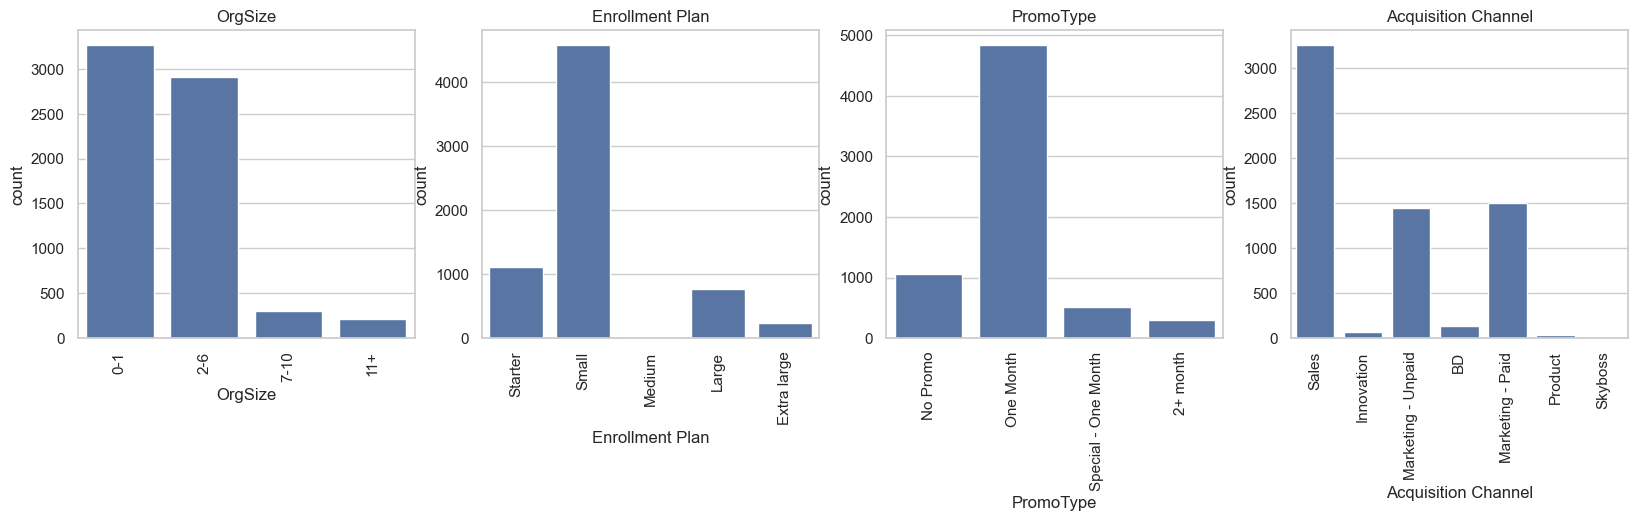

In [7]:
cols = ['OrgSize',"Enrollment Plan", 'PromoType', 'Acquisition Channel']
numerical = cols

plt.figure(figsize=(20,4))

for i, col in enumerate(numerical):
    ax = plt.subplot(1, len(numerical), i+1)
    sns.countplot(x=str(col), data=df_churned)
    ax.set_title(f"{col}")
    #rotate x-axis labels
    plt.xticks(rotation=90)

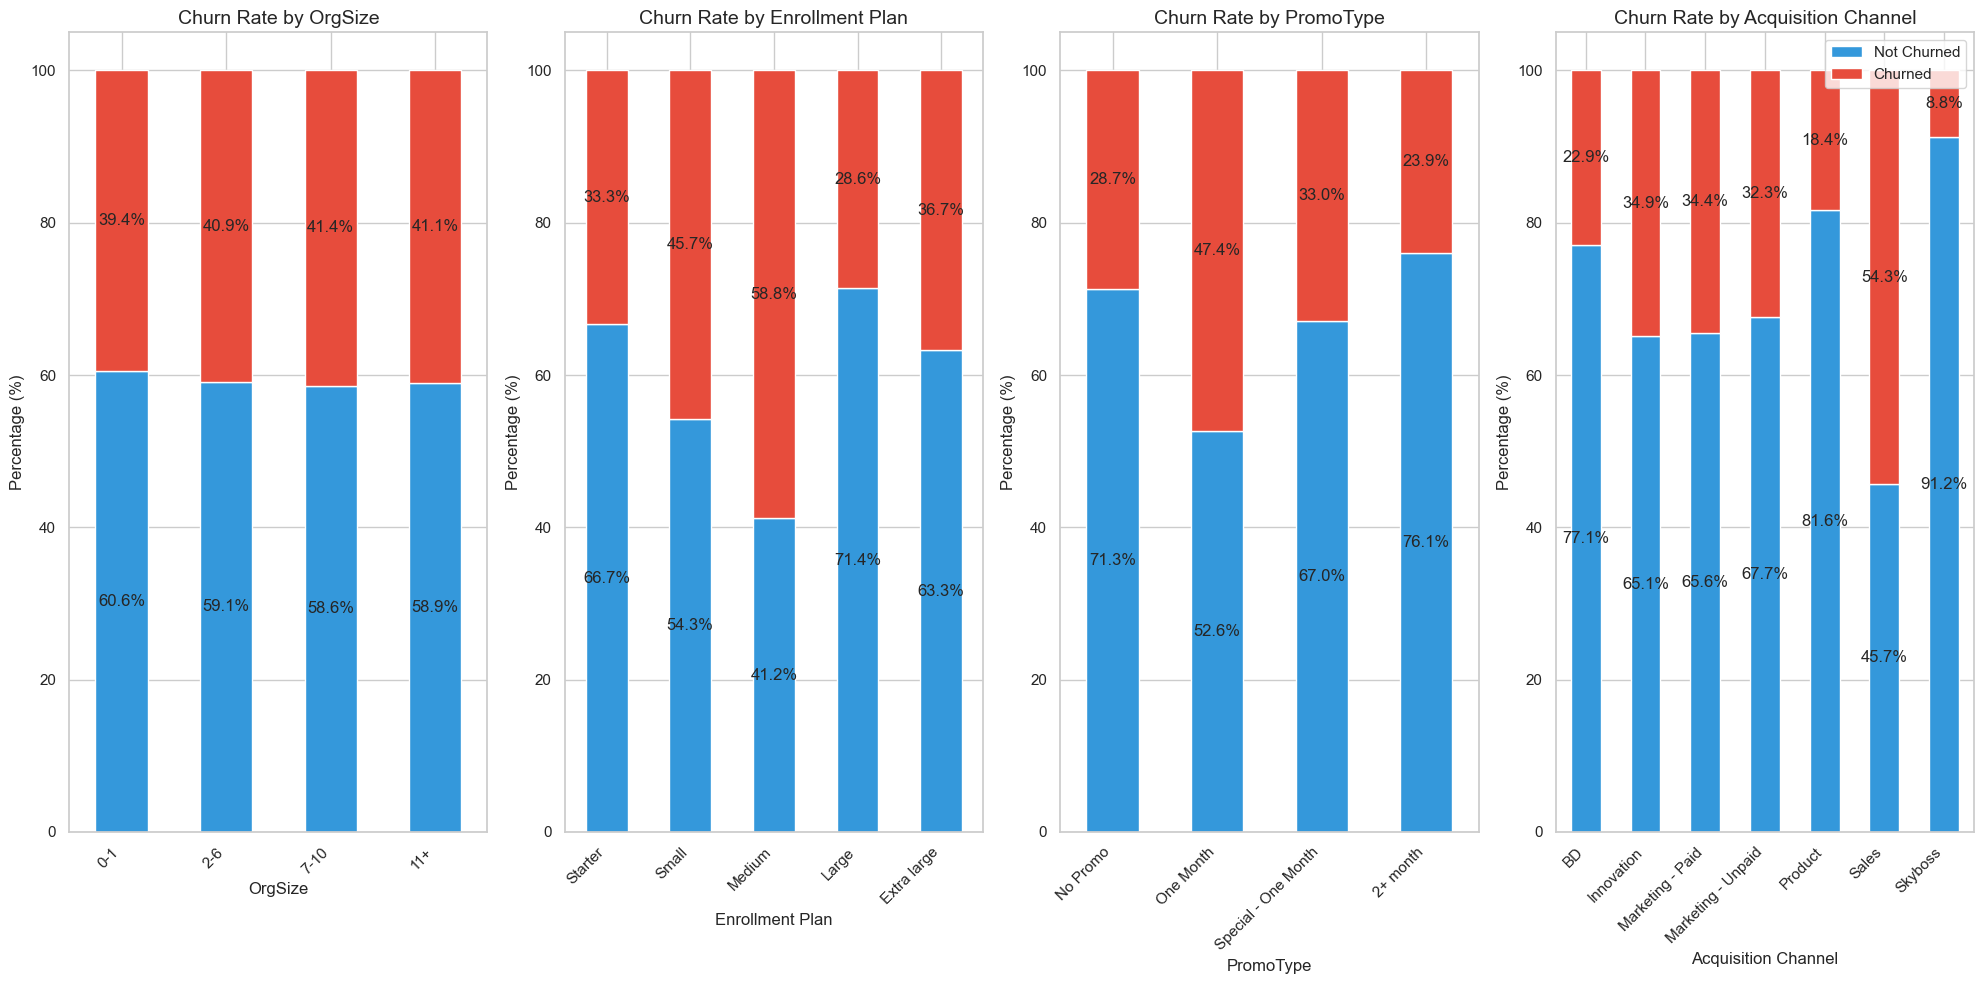

In [ ]:
# List of categorical columns to analyze
cols = ['OrgSize', 'Enrollment Plan', 'PromoType', 'Acquisition Channel']

# Create figure
plt.figure(figsize=(20, 10))

# Loop through each column
for i, col in enumerate(cols):
    # Create subplot
    ax = plt.subplot(1, len(cols), i+1)
    
    # Create a cross-tabulation of the categorical variable vs churn
    # Assuming 'Churned' is your target column with boolean/binary values
    ct = pd.crosstab(df[col], df['Churned'])
    
    # Convert to percentages (100% stacked)
    ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
    
    # Plot the stacked bar chart
    ct_pct.plot(kind='bar', stacked=True, ax=ax, 
               color=['#3498db', '#e74c3c'])  # Blue for not churned, red for churned
    
    # Set title and labels
    ax.set_title(f"Churn Rate by {col}", fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    
    # Add legend only to the last subplot to avoid repetition
    if i == len(cols) - 1:
        plt.legend(['Not Churned', 'Churned'], loc='upper right')
    else:
        ax.get_legend().remove()
    
    # Add percentage labels on the bars
    for c in ax.containers:
        # Add labels for segments over 5% to avoid clutter
        labels = [f'{v:.1f}%' if v > 5 else '' for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='center')
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.show()

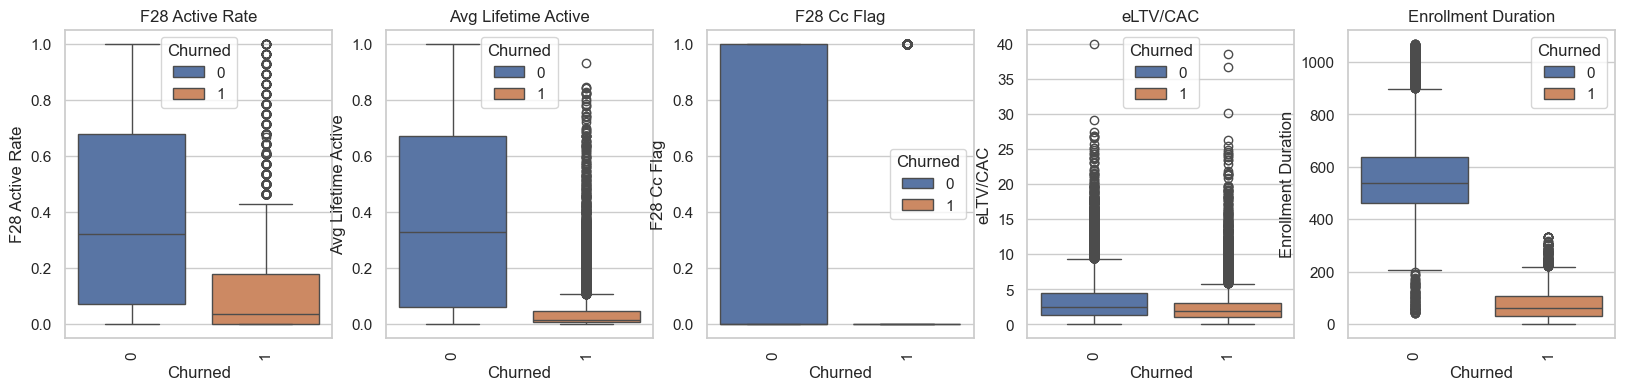

In [8]:
cols = ['F28 Active Rate',"Avg Lifetime Active", 'F28 Cc Flag', 'eLTV/CAC', 'Enrollment Duration']
numerical = cols

plt.figure(figsize=(20,4))

for i, col in enumerate(numerical):
    ax = plt.subplot(1, len(numerical), i+1)
    sns.boxplot(x='Churned', y=str(col), data=df, hue = 'Churned')
    ax.set_title(f"{col}")
    #rotate x-axis labels
    plt.xticks(rotation=90)

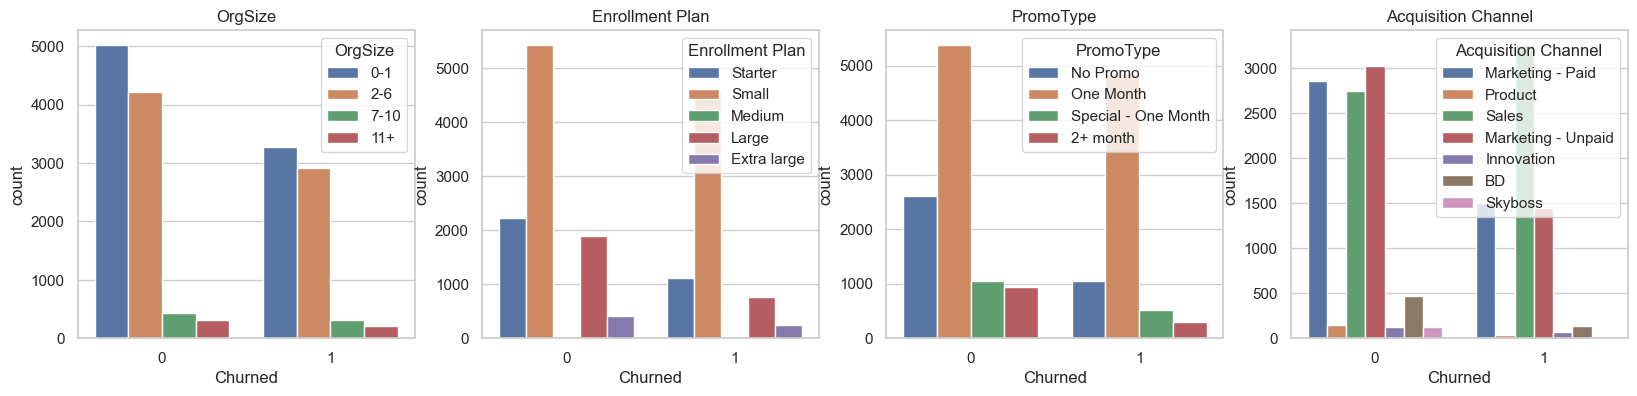

In [9]:
cols = ['OrgSize',"Enrollment Plan", 'PromoType', 'Acquisition Channel']

plt.figure(figsize=(20,4))

for i, col in enumerate(cols):
    ax = plt.subplot(1, len(cols), i+1)
    sns.countplot(x ="Churned", hue = str(col), data = df)
    ax.set_title(f"{col}")
    

In [11]:
df2 = df.copy()
df2['EnrollYear'] = pd.DatetimeIndex(df['EnrollDate']).year
df2['EnrollMonth'] = pd.DatetimeIndex(df['EnrollDate']).year
df2['ChurnYear'] = pd.DatetimeIndex(df['ChurnDate']).year
df2['ChurnMonth'] = pd.DatetimeIndex(df['ChurnDate']).year
df2.head()

,OrgID,EnrollDate,ChurnDate,OrgSize,Industry,IndustryGroup,Enrollment Plan,PromoType,Acquisition Channel,F28 Active Rate,Avg Lifetime Active,F28 Cc Flag,eLTV/CAC,Churned,Enrollment Duration,User_id,EnrollYear,EnrollMonth,ChurnYear,ChurnMonth
0,44,2021-02-01,NaT,0-1,Flooring,Other,Extra large,No Promo,Marketing - Paid,0.607,0.096,0,4.1,0,676.0,4420210201,2021,2021,NaN,NaN
1,70,2022-03-01,NaT,0-1,Plumbing,Plumbing,Starter,No Promo,NaN,0.071,0.340,0,1.2,0,283.0,7020220301,2022,2022,NaN,NaN
2,1494,2020-10-02,NaT,0-1,Carpet Cleaning,Carpet Cleaning,Small,No Promo,Product,1.000,0.379,1,3.4,0,798.0,149420201002,2020,2020,NaN,NaN
3,1604,2020-10-08,2020-12-08,11+,Restoration,Other,Large,2+ month,Sales,0.500,0.004,0,6.2,1,61.0,160420201008,2020,2020,2020.0,2020.0
4,1652,2020-02-03,2020-03-02,11+,Solar & Energy,Other,Large,One Month,Sales,0.000,0.001,0,4.7,1,28.0,165220200203,2020,2020,2020.0,2020.0


In [15]:
df_churned_year = df2.dropna(subset=['ChurnYear'])

# Group by ChurnYear and calculate the percentage of churned users
churn_percentage_per_year = df_churned_year.groupby('EnrollYear').size() / df2.groupby('EnrollYear').size() * 100

# Display the result
print(churn_percentage_per_year)

print(churn_percentage_per_year.mean())

EnrollYear
2020    44.280206
2021    39.679238
2022    45.495495
dtype: float64
43.1516462790797
